In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df =  pd.read_csv("viewParkingLot.csv")
df

,vehicle_no,timestamp,camera_id
0,MHUN7063,2024-09-12 05:00:00,1
1,MHYN4677,2024-09-12 05:00:00,1
2,MHEL6595,2024-09-12 05:00:00,1
3,MHNQ2590,2024-09-12 05:00:00,1
4,MHHA0518,2024-09-12 05:00:00,1
...,...,...,...
106689,MHCN7114,2024-11-14 00:00:00,2
106690,MHVY8418,2024-11-14 00:00:00,2
106691,MHSR8102,2024-11-14 00:00:00,2
106692,MHQG5264,2024-11-14 00:00:00,2


In [3]:
df =  pd.read_csv("viewParkingLot.csv")
df.columns

Index(['vehicle_no ', 'timestamp           ', 'camera_id'], dtype='object')

In [4]:
df['vehicle_no'] = df['vehicle_no '].str.upper().astype('string')
df['timestamp'] = df['timestamp           '].str.upper().astype('string')
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
df = df.drop('vehicle_no ', axis=1)
df = df.drop('timestamp           ', axis=1)
df['vehicle_no'] = df['vehicle_no'].str.strip()
df = df.sort_values(by='timestamp')
df

,camera_id,vehicle_no,timestamp
0,1,MHUN7063,2024-09-12 05:00:00
21,1,MHMY1867,2024-09-12 05:00:00
20,1,MHZF8417,2024-09-12 05:00:00
19,1,MHFU6425,2024-09-12 05:00:00
18,1,MHHB4038,2024-09-12 05:00:00
...,...,...,...
106675,2,MHEV1001,2024-11-14 00:00:00
106674,2,MHGL7893,2024-11-14 00:00:00
106692,2,MHQG5264,2024-11-14 00:00:00
106682,2,MHBB9719,2024-11-14 00:00:00


In [5]:
# count the number of vehicles entering on each date

df['date'] = df['timestamp'].dt.date
df['date'] = pd.to_datetime(df['date'])

cars_entering  = df[df['camera_id']==1]
n_cars_entering = cars_entering.groupby('date', as_index=False).count()
n_cars_entering = n_cars_entering.drop(['timestamp', 'vehicle_no'], axis=1)
n_cars_entering.columns  = ['date', 'n_cars_entering']
n_cars_entering['date'] = pd.to_datetime(n_cars_entering['date'])
n_cars_entering

,date,n_cars_entering
0,2024-09-12,886
1,2024-09-13,809
2,2024-09-14,925
3,2024-09-15,1073
4,2024-09-16,843
...,...,...
58,2024-11-09,906
59,2024-11-10,944
60,2024-11-11,828
61,2024-11-12,806


In [6]:
mean_cars_entering = n_cars_entering['n_cars_entering'].mean()

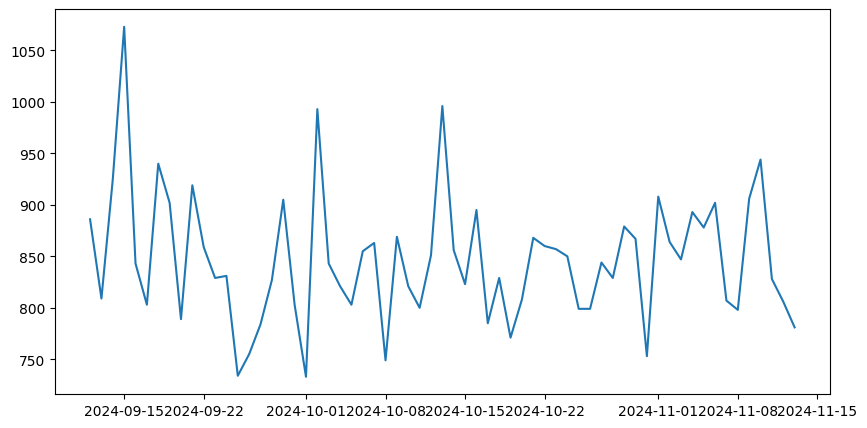

In [7]:
# n_cars_entering.plot(x=n_cars_entering['date'], y=n_cars_entering['n_cars_entering'] ,kind='line', figsize=(10,5))\
#plot the number of cars entering on each date
plt.figure(figsize=(10,5))
plt.plot(n_cars_entering['date'], n_cars_entering['n_cars_entering'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

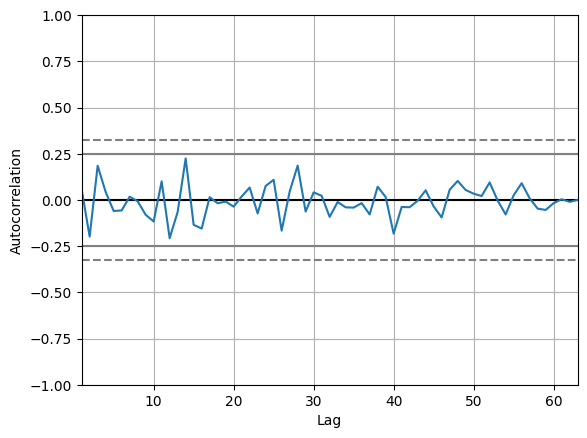

In [8]:
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(n_cars_entering['n_cars_entering'])

In [9]:
#import min max scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

#scale the data
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(n_cars_entering[['n_cars_entering']])
scaled_data = pd.DataFrame(scaled_values, columns=['n_cars_entering'])
scaled_data['date'] = n_cars_entering['date'].values
scaled_data = scaled_data[['date', 'n_cars_entering']]
scaled_data

,date,n_cars_entering
0,2024-09-12,0.450000
1,2024-09-13,0.223529
2,2024-09-14,0.564706
3,2024-09-15,1.000000
4,2024-09-16,0.323529
...,...,...
58,2024-11-09,0.508824
59,2024-11-10,0.620588
60,2024-11-11,0.279412
61,2024-11-12,0.214706


In [10]:
new_df = scaled_data.set_index(['date'], drop=True)
new_df

,n_cars_entering
date,
2024-09-12,0.450000
2024-09-13,0.223529
2024-09-14,0.564706
2024-09-15,1.000000
2024-09-16,0.323529
...,...
2024-11-09,0.508824
2024-11-10,0.620588
2024-11-11,0.279412


In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression

vehicles_per_day = new_df.reset_index()
vehicles_per_day['day_of_week'] = vehicles_per_day['date'].apply(lambda x: x.weekday())
vehicles_per_day['day_of_week'] = vehicles_per_day['day_of_week'].astype('category')

vehicles_per_day['day_of_week'] = vehicles_per_day['day_of_week'].cat.codes

X = vehicles_per_day[['day_of_week']]
y = vehicles_per_day['n_cars_entering']

size = int(len(X) * 0.8)
train_X, test_X = X[0:size], X[size:len(X)]
train_y, test_y = y[0:size], y[size:len(y)]

model = LinearRegression()
model.fit(train_X, train_y)
predictions = model.predict(test_X)

print(mean_absolute_error(test_y, predictions))

0.12799242774032688


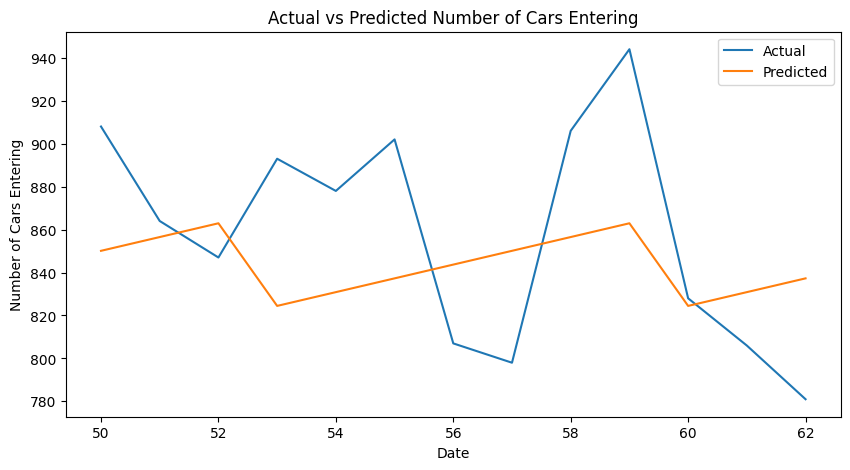

In [12]:
# Unscale the predicted data
unscaled_predictions = scaler.inverse_transform(predictions.reshape(-1, 1))

# Create a DataFrame for the unscaled predictions
predicted_df = pd.DataFrame(unscaled_predictions, columns=['n_cars_entering'])
predicted_df['date'] = test_X.index
predicted_df = predicted_df.set_index('date')

# Unscale the actual data
unscaled_actual = scaler.inverse_transform(test_y.values.reshape(-1, 1))

# Create a DataFrame for the unscaled actual data
actual_df = pd.DataFrame(unscaled_actual, columns=['n_cars_entering'])
actual_df['date'] = test_X.index
actual_df = actual_df.set_index('date')

# Plot the actual vs predicted data
plt.figure(figsize=(10, 5))
plt.plot(actual_df.index, actual_df['n_cars_entering'], label='Actual')
plt.plot(predicted_df.index, predicted_df['n_cars_entering'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Cars Entering')
plt.title('Actual vs Predicted Number of Cars Entering')
plt.legend()
plt.show()

43.51742543171117
5.139178964511226


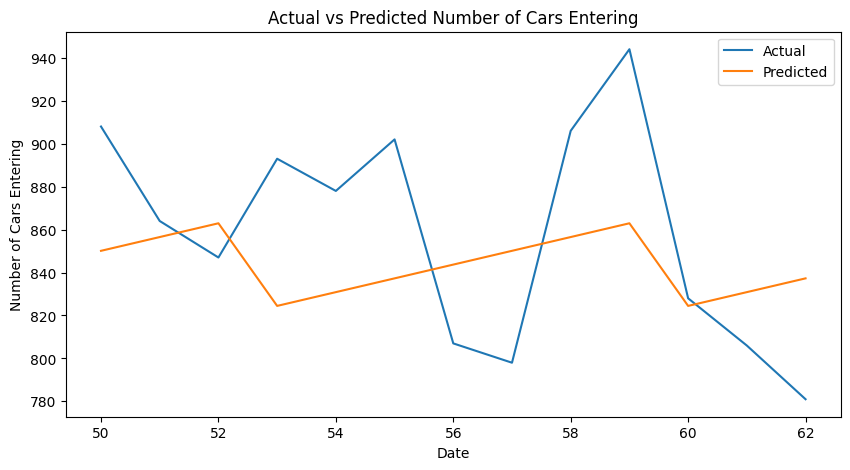

In [13]:
unscaled_pred = scaler.inverse_transform(predictions.reshape(-1,1))

predicted_df = pd.DataFrame(unscaled_pred, columns=['n_cars_entering'])
predicted_df['date'] = test_X.index
predicted_df = predicted_df.set_index('date')

unscaled_actual = scaler.inverse_transform(test_y.values.reshape(-1,1))

actual_df = pd.DataFrame(unscaled_actual, columns=['n_cars_entering'])
actual_df['date'] = test_X.index
actual_df = actual_df.set_index('date')

plt.figure(figsize=(10, 5))
plt.plot(actual_df.index, actual_df['n_cars_entering'], label='Actual')
plt.plot(predicted_df.index, predicted_df['n_cars_entering'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Cars Entering')
plt.title('Actual vs Predicted Number of Cars Entering')
plt.legend()
print(mean_absolute_error(actual_df['n_cars_entering'], predicted_df['n_cars_entering']))
print(mean_absolute_error(actual_df['n_cars_entering'], predicted_df['n_cars_entering'])*100/mean_cars_entering)
